In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',None)

data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

# PipeLine

In [2]:
import itertools
from tqdm import tqdm
from datetime import datetime, timedelta
pd.set_option('mode.chained_assignment',  None)
class Processing:
    def __init__(self, x, test): # 이후 테스트 데이터도 넣는 버전 만들어야함
        self.x = x
        self.test = test
    
    def to_time(self, data, where = None):
        if where == None:
            print('where 넣어야함')
            return None
        
        def to_time(time_list):
            if where == 'first':
                Time = pd.Series(time_list).astype(str).str.zfill(4)
                Time = Time.replace('2400','0000')
                return [datetime.strptime(i, '%H%M').strftime("%H:%M") if i != '0nan' else np.NaN for i in Time]
            
            elif where == 'twice':
                Time = pd.Series(time_list)
                Time = Time.replace('2400','0000')
                # Time = Time.replace('9999','1557')
                return [datetime.strptime(i, '%H%M').strftime("%H:%M") for i in Time]  
        
        def time_gb(x):
            if x < 600:
                return '0000-0600'
            elif x >= 600 and x <= 659:
                return '0600-0659'
            elif x>=1400 and x<=1459:
                return '1400-1459'
            elif x>=1200 and x<=1259:
                return '1200-1259'
            elif x>=1500 and x<=1559:
                return '1500-1559'
            elif x>=1900 and x<=1959:
                return '1900-1959'
            elif x>=900 and x<=959:
                return '0900-0959'
            elif x>=1000 and x<=1059:
                return  '1000-1059'
            elif x>=2000 and x<=2059:
                return '2000-2059'
            elif x>=1300 and x<=1359:
                return '1300-1359'
            elif x>=1100 and x<=1159:
                return '1100-1159'
            elif x>=800 and x<=859:
                return '0800-0859'
            elif x>=2200 and x<=2259:
                return '2200-2259'
            elif x>=1600 and x<=1659:
                return '1600-1659'
            elif x>=1700 and x<=1759:
                return '1700-1759'
            elif x>=2100 and x<=2159:
                return '2100-2159'
            elif x>=700 and x<=759:
                return '0700-0759'
            elif x>=1800 and x<=1859:
                return '1800-1859'
            elif x>=1 and x<=559:
                return '0001-0559'
            elif x>=2300 and x<=2400:
                return '2300-2400'
            
        def distance_gb(x):
            if x < 700 :
                return 'short_route'
            elif x>=700 and x<3000:
                return 'mid_route'
            elif x>=3000:
                return 'long_route'    
        
        if where == 'first':
            time_list = [i if str(i) == 'nan' else str(int(i))  for i in data['Estimated_Departure_Time'] ]
            time_list1 = [i if str(i) == 'nan' else str(int(i))  for i in data['Estimated_Arrival_Time'] ]
            
        elif where == 'twice':
            time_list = [i for i in data['Estimated_Departure_Time']]
            time_list1 = [i for i in data['Estimated_Arrival_Time']]
        data['Estimated_Departure_Time_HH:MM'] = to_time(time_list)
        data['Estimated_Arrival_Time_HH:MM'] = to_time(time_list1)
    
        
        # 예상 비행시간 만들기 (분으로 만들기)
        data_est_time = []
        for i,j in zip(data['Estimated_Arrival_Time_HH:MM'], data['Estimated_Departure_Time_HH:MM']):
            if str(i) != 'nan' and str(j) != 'nan':
                if (datetime.strptime(str(i), "%H:%M") - datetime.strptime(str(j), "%H:%M")).total_seconds()/60 >= 0:
                    data_est_time.append((datetime.strptime(str(i), "%H:%M") - datetime.strptime(str(j), "%H:%M")).total_seconds()/60)
                else:
                    time = datetime.strptime(str(i), "%H:%M") - datetime.strptime(str(j), "%H:%M") + datetime.strptime('23:59', "%H:%M") + timedelta(minutes=1)
                    data_est_time.append(timedelta(hours=time.hour,minutes=time.minute ).total_seconds()/60)
            else:
                data_est_time.append(np.NaN)
        
        if where == 'first':
            data['Estimated_Time'] = data_est_time
            data['Dep_time_gb'] = data['Estimated_Departure_Time'].dropna().apply(time_gb)
            data['Arr_time_gb'] = data['Estimated_Arrival_Time'].dropna().apply(time_gb)
            data['route_gb'] = data['Distance'].apply(distance_gb)
            
        elif where == 'twice':
            data['Estimated_Time'] = data_est_time
            data['Dep_time_gb'] = data['Estimated_Departure_Time'].astype(int).apply(time_gb)
            data['Arr_time_gb'] = data['Estimated_Arrival_Time'].astype(int).apply(time_gb)
            data['route_gb'] = data['Distance'].apply(distance_gb)
        
        return data
        
    
    def fill_airline_and_id(self, data):
        
        for airline in data['Airline'].dropna().unique():
            id = data.loc[data['Airline'] == airline, 'Carrier_ID(DOT)'].dropna().unique()
            data.loc[data['Airline'] == airline, 'Carrier_ID(DOT)'] = id[0]
                

        for id in data['Carrier_ID(DOT)'].dropna().unique():
            airline = data.loc[data['Carrier_ID(DOT)'] == id, 'Airline'].dropna().unique()
            data.loc[data['Carrier_ID(DOT)'] == id, 'Airline'] = airline[0]
            
        return data
    
    def fill_state(self, data):
        for id in data['Origin_Airport_ID'].dropna().unique():
            # 테스트셋에 알수없는 Origin State -> dummy로 채움
            try:
                data.loc[data['Origin_Airport_ID'] == id, 'Origin_State'] = data.loc[data['Origin_Airport_ID'] == id, 'Origin_State'].dropna().unique()[0]
            except:
                data.loc[data['Origin_Airport_ID'] == id, 'Origin_State'] = 'dummy'
        
        for id in data['Destination_Airport_ID'].dropna().unique():
            try:
                data.loc[data['Destination_Airport_ID'] == id, 'Destination_State'] = data.loc[data['Destination_Airport_ID'] == id, 'Destination_State'].dropna().unique()[0]
            except: # 기록이 하나밖에 없음. Youngstown (YNG 공항)
                data.loc[data['Destination_Airport_ID'] == id, 'Destination_State'] = 'Youngstown'
        return data
        
    def fill_timedata(self, data, where=None):
        if where == 'at':
            time1 = 'Estimated_Departure_Time'
            time2 = 'Estimated_Arrival_Time'
            
        elif where == 'dt':
            time1 = 'Estimated_Arrival_Time'
            time2 = 'Estimated_Departure_Time'
            
        elif where == 'both':
            b_data = data[~((data['Estimated_Arrival_Time'].isna()) & (data['Estimated_Departure_Time'].isna()))]
            b_data = b_data.groupby(['Origin_Airport', 'Destination_Airport'])['Estimated_Arrival_Time', 'Estimated_Departure_Time'].value_counts()
            b_data = b_data.reset_index()
            b_data = b_data.rename(columns={0:'count'})
            b_data = b_data.sort_values(['Origin_Airport', 'Destination_Airport', 'count'], ascending=False)
            b_data = b_data.drop_duplicates(subset=['Origin_Airport', 'Destination_Airport'], keep='first')

            b_data = b_data.set_index(['Origin_Airport', 'Destination_Airport']).drop('count', axis=1)

            b = data[(data['Estimated_Arrival_Time'].isna()) & (data['Estimated_Departure_Time'].isna())]
            b = b.set_index(['Origin_Airport', 'Destination_Airport'])

            b[['Estimated_Arrival_Time', 'Estimated_Departure_Time']] = b_data[['Estimated_Arrival_Time', 'Estimated_Departure_Time']]
            
            return b.reset_index()
        
        else:
            print('Where 값을 채워주세요. at: 도착시간 보간, dt: 출발시간 보간')
            return None
            
            
        
        # 같은 출발/도착시간이 있을 경우 가장 많은 출발/도착시간으로 채움
        merge_data = data.groupby(['Origin_Airport', 'Destination_Airport', 'Airline'])[time2, time1, 'Estimated_Time'].value_counts()
        merge_data = merge_data.reset_index()
        merge_data = merge_data.rename(columns={0:'count'})
        merge_data = merge_data[~((merge_data[time1].isna()) & (merge_data[time2].isna()))]
        merge_data = merge_data.sort_values(['Origin_Airport', 'Destination_Airport', 'count'], ascending=False)
        merge_data = merge_data.drop_duplicates(subset=['Origin_Airport', 'Destination_Airport', time1], keep='first')
        mt = data.loc[(data[time2].isna()) & ~(data[time1].isna()), ['Origin_Airport', 'Destination_Airport',time2, time1]]
        mt = mt.drop(time2, axis=1)
        mt = pd.merge(mt, merge_data, how='left', on =['Origin_Airport', 'Destination_Airport', time1])

        # 같은 출발/도착시간이 없을 경우 출도착공항 Estimated_Time이 가장 많은 시간을 채우고 출발/도착시간을 계산
        et = merge_data.groupby(['Origin_Airport', 'Destination_Airport', 'Airline'])[['Estimated_Time']].value_counts()
        et = et.reset_index()
        et = et.rename(columns={0:'count'})
        et = et.sort_values(['Origin_Airport', 'Destination_Airport', 'Airline', 'count'], ascending=False)
        et = et.drop_duplicates(subset=['Origin_Airport', 'Destination_Airport', 'Airline'], keep='first').drop(['count'], axis=1)
        mt2 = mt[mt[time2].isna()].drop(['Estimated_Time', 'count'], axis=1)
        mt2 = pd.merge(mt2, et, how='left', on =['Origin_Airport', 'Destination_Airport', 'Airline'])

        # # mt2-mt 합침
        mt= mt.set_index(['Origin_Airport', 'Destination_Airport', 'Airline'])
        mt2= mt2.reset_index().set_index(['Origin_Airport', 'Destination_Airport', 'Airline'])
        mt.loc[mt['Estimated_Time'].isna(), 'Estimated_Time'] = mt2['Estimated_Time']

        # # mt-data 합침 (따로 분리하여 나중에 한번에 채움. 보간한 값을 보간할 때 사용하지 않기 위함)
        mt = mt.drop('count', axis=1).reset_index().set_index(['Origin_Airport', 'Destination_Airport', time1])
        fill_data = data[~(data[time1].isna()) & (data[time2].isna())]
        fill_data = fill_data.set_index(['Origin_Airport', 'Destination_Airport', time1])
        fill_data[[time2, 'Estimated_Time']] = mt[[time2, 'Estimated_Time']]
        fill_data = fill_data.reset_index()
    
        return fill_data
    
    # 시간 채우는 함수
    def fill_time(self, data, where = None):
        at_data = self.fill_timedata(data, where='at')
        dt_data = self.fill_timedata(data, where='dt')
        b_data = self.fill_timedata(data, where='both')

        data = data.set_index('ID')
        at_data = at_data.set_index('ID')
        dt_data = dt_data.set_index('ID')
        b_data = b_data.set_index('ID')
        
        data.loc[(data['Estimated_Arrival_Time'].isna()) & ~(data['Estimated_Departure_Time'].isna()), ['Estimated_Arrival_Time', 'Estimated_Time']] = at_data[['Estimated_Arrival_Time', 'Estimated_Time']]
        data.loc[(data['Estimated_Departure_Time'].isna())  & ~(data['Estimated_Arrival_Time'].isna()), ['Estimated_Departure_Time', 'Estimated_Time']] = dt_data[['Estimated_Departure_Time', 'Estimated_Time']]
        data.loc[(data['Estimated_Departure_Time'].isna()) & (data['Estimated_Arrival_Time'].isna()), ['Estimated_Departure_Time', 'Estimated_Arrival_Time', 'Estimated_Time']] = b_data[['Estimated_Departure_Time', 'Estimated_Arrival_Time', 'Estimated_Time']]
        data['Estimated_Departure_Time'] = data['Estimated_Departure_Time'].fillna(9999).astype(int).astype(str)
        data['Estimated_Departure_Time'] = data['Estimated_Departure_Time'].str.zfill(4)
        data['Estimated_Arrival_Time'] = data['Estimated_Arrival_Time'].fillna(9999).astype(int).astype(str)
        data['Estimated_Arrival_Time'] = data['Estimated_Arrival_Time'].str.zfill(4)
        
        # apply용 함수
        def arr_time(x):
            try:
                x['Estimated_Departure_Time'] = x['Estimated_Departure_Time'].replace('2400','0000')
                time = datetime.strptime(x['Estimated_Departure_Time'], "%H%M") + timedelta(minutes=x['Estimated_Time'])
                hour = str(time.hour).zfill(2)
                minute = str(time.minute).zfill(2)
                x['Estimated_Arrival_Time'] = hour+minute        
            except:
                pass
            
            return x

        def dep_time(x):
            try:
                x['Estimated_Arrival_Time'] = x['Estimated_Arrival_Time'].replace('2400','0000')
                time = datetime.strptime(x['Estimated_Arrival_Time'], "%H%M") - timedelta(minutes=x['Estimated_Time'])
                hour = str(time.hour).zfill(2)
                minute = str(time.minute).zfill(2)
                x['Estimated_Departure_Time'] = hour+minute        
            except:
                pass
            
            return x
        
        add_time = data.loc[(data['Estimated_Arrival_Time'] == '9999') & (data['Estimated_Departure_Time'] != '9999'), ['Estimated_Departure_Time', 'Estimated_Time', 'Estimated_Arrival_Time']]
        t = add_time.apply(arr_time, axis=1)
        t= t[~t['Estimated_Time'].isna()]
        data.loc[t.index, 'Estimated_Arrival_Time'] = t['Estimated_Arrival_Time']
        
        add_time = data.loc[(data['Estimated_Arrival_Time'] != '9999') & (data['Estimated_Departure_Time'] == '9999'), ['Estimated_Arrival_Time', 'Estimated_Time', 'Estimated_Departure_Time']]
        t = add_time.apply(dep_time, axis=1)
        t= t[~t['Estimated_Time'].isna()]
        data.loc[t.index, 'Estimated_Departure_Time'] = t['Estimated_Departure_Time']
        
        # if where == 'test':
        #     test = data[~data['Estimated_Time'].isna()]
        #     test = data[data['Estimated_Time'] != 'nan']
        #     test = test[test['Estimated_Arrival_Time'] != '9999']
        #     test = test[test['Estimated_Departure_Time'] != '9999']
            
        #     return test, data
            

        # data = data[~data['Estimated_Time'].isna()]
        # data = data[data['Estimated_Time'] != 'nan']

        
        return data
    
    
    
    def train_processing(self):
        data = self.fill_airline_and_id(self.x)
        data = self.fill_state(data)
        data = self.to_time(data, where='first')
        data = self.fill_time(data)
        return data
        
        data = self.to_time(data, where='twice')
        
        return data
    
    
    def test_processing(self):
        data = self.fill_airline_and_id(self.test)
        data = self.fill_state(data)
        data = self.to_time(data, where='first')
        data  = self.fill_time(data, where='test')
        return data
        
        data = self.to_time(data, where='twice')
        # return data
    
        return data, origin

In [3]:
pc = Processing(data, test)

train = pc.train_processing()
test = pc.test_processing()

C:\Users\signlab026\AppData\Local\Temp\ipykernel_25336\4052965858.py:176: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  merge_data = data.groupby(['Origin_Airport', 'Destination_Airport', 'Airline'])[time2, time1, 'Estimated_Time'].value_counts()
C:\Users\signlab026\AppData\Local\Temp\ipykernel_25336\4052965858.py:176: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  merge_data = data.groupby(['Origin_Airport', 'Destination_Airport', 'Airline'])[time2, time1, 'Estimated_Time'].value_counts()
C:\Users\signlab026\AppData\Local\Temp\ipykernel_25336\4052965858.py:154: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  b_data = b_data.groupby(['Origin_Airport', 'Destination_Airport'])['Estimated_Arrival_Time', 'Estimated_Departure_Time'].value_counts()
C:\User

In [4]:


def to_time2(data):
    def to_time(time_list):
        Time = pd.Series(time_list).astype(str).str.zfill(4)
        Time = Time.replace('2400','0000')
        return [datetime.strptime(i, '%H%M').strftime("%H:%M") if i != '0nan' else np.NaN for i in Time]
        


    def time_gb(x):
        try:
            if x < 600:
                return '0000-0600'
            elif x >= 600 and x <= 659:
                return '0600-0659'
            elif x>=1400 and x<=1459:
                return '1400-1459'
            elif x>=1200 and x<=1259:
                return '1200-1259'
            elif x>=1500 and x<=1559:
                return '1500-1559'
            elif x>=1900 and x<=1959:
                return '1900-1959'
            elif x>=900 and x<=959:
                return '0900-0959'
            elif x>=1000 and x<=1059:
                return  '1000-1059'
            elif x>=2000 and x<=2059:
                return '2000-2059'
            elif x>=1300 and x<=1359:
                return '1300-1359'
            elif x>=1100 and x<=1159:
                return '1100-1159'
            elif x>=800 and x<=859:
                return '0800-0859'
            elif x>=2200 and x<=2259:
                return '2200-2259'
            elif x>=1600 and x<=1659:
                return '1600-1659'
            elif x>=1700 and x<=1759:
                return '1700-1759'
            elif x>=2100 and x<=2159:
                return '2100-2159'
            elif x>=700 and x<=759:
                return '0700-0759'
            elif x>=1800 and x<=1859:
                return '1800-1859'
            elif x>=1 and x<=559:
                return '0001-0559'
            elif x>=2300 and x<=2400:
                return '2300-2400'
        
        except:
            return 'dummy'
        
    def distance_gb(x):
        if x < 700 :
            return 'short_route'
        elif x>=700 and x<3000:
            return 'mid_route'
        elif x>=3000:
            return 'long_route'    

    time_list = [i if str(i) == 'nan' else str(int(i))  for i in data['Estimated_Departure_Time'] ]
    time_list1 = [i if str(i) == 'nan' else str(int(i))  for i in data['Estimated_Arrival_Time'] ]

    data['Estimated_Departure_Time_HH:MM'] = to_time(time_list)
    data['Estimated_Arrival_Time_HH:MM'] = to_time(time_list1)


    # 예상 비행시간 만들기 (분으로 만들기)
    data_est_time = []
    for i,j in zip(data['Estimated_Arrival_Time_HH:MM'], data['Estimated_Departure_Time_HH:MM']):
        if str(i) != 'nan' and str(j) != 'nan':
            if (datetime.strptime(str(i), "%H:%M") - datetime.strptime(str(j), "%H:%M")).total_seconds()/60 >= 0:
                data_est_time.append((datetime.strptime(str(i), "%H:%M") - datetime.strptime(str(j), "%H:%M")).total_seconds()/60)
            else:
                time = datetime.strptime(str(i), "%H:%M") - datetime.strptime(str(j), "%H:%M") + datetime.strptime('23:59', "%H:%M") + timedelta(minutes=1)
                data_est_time.append(timedelta(hours=time.hour,minutes=time.minute ).total_seconds()/60)
        else:
            data_est_time.append(np.NaN)

    data['Estimated_Time'] = data_est_time
    data['Dep_time_gb'] = data['Estimated_Departure_Time'].dropna().astype(float).apply(time_gb)
    data['Arr_time_gb'] = data['Estimated_Arrival_Time'].dropna().astype(float).apply(time_gb)
    data['route_gb'] = data['Distance'].apply(distance_gb)
        
    return data

train = train.replace('9999', np.NaN)
test = test.replace('9999', np.NaN)

train = to_time2(train)
test = to_time2(test)

In [5]:
train[train['route_gb'] == 'long_route']['Delay'].value_counts()

Not_Delayed    350
Delayed         62
Name: Delay, dtype: int64

In [10]:
train

,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay,Estimated_Departure_Time_HH:MM,Estimated_Arrival_Time_HH:MM,Estimated_Time,Dep_time_gb,Arr_time_gb,route_gb
ID,,,,,,,,,,,,,,,,,,,,,,,,
TRAIN_000000,4,15,1455,1620,0,0,OKC,13851,Oklahoma,HOU,12191,Texas,419.0,Southwest Airlines Co.,WN,19393.0,N7858A,NaN,14:55,16:20,85.0,1400-1459,1600-1659,short_route
TRAIN_000001,8,15,0740,1024,0,0,ORD,13930,Illinois,SLC,14869,Utah,1250.0,SkyWest Airlines Inc.,UA,20304.0,N125SY,NaN,07:40,10:24,164.0,0700-0759,1000-1059,mid_route
TRAIN_000002,9,6,1610,1805,0,0,CLT,11057,North Carolina,LGA,12953,New York,544.0,American Airlines Inc.,AA,19805.0,N103US,NaN,16:10,18:05,115.0,1600-1659,1800-1859,short_route
TRAIN_000003,7,10,0905,1735,0,0,LAX,12892,California,EWR,11618,New Jersey,2454.0,United Air Lines Inc.,UA,19977.0,N595UA,NaN,09:05,17:35,510.0,0900-0959,1700-1759,mid_route
TRAIN_000004,1,11,0900,1019,0,0,SFO,14771,California,ACV,10157,California,250.0,SkyWest Airlines Inc.,UA,20304.0,N161SY,NaN,09:00,10:19,79.0,0900-0959,1000-1059,short_route
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRAIN_999995,9,18,0936,1243,0,0,ORD,13930,Illinois,PHL,14100,Pennsylvania,678.0,United Air Lines Inc.,UA,19977.0,N477UA,NaN,09:36,12:43,187.0,0900-0959,1200-1259,short_route
TRAIN_999996,5,30,0920,1028,0,0,FAR,11637,North Dakota,MSP,13487,Minnesota,223.0,SkyWest Airlines Inc.,DL,20304.0,N439SW,NaN,09:20,10:28,68.0,0900-0959,1000-1059,short_route
TRAIN_999997,6,28,0800,1340,0,0,OAK,13796,California,HOU,12191,Texas,1642.0,Southwest Airlines Co.,WN,19393.0,N230WN,NaN,08:00,13:40,340.0,0800-0859,1300-1359,mid_route


In [6]:
def FE(x):
    x = x.drop(['Cancelled', 'Diverted', 'Estimated_Departure_Time', 'Estimated_Arrival_Time', 
                'Destination_Airport_ID', 'Estimated_Arrival_Time_HH:MM', 'Origin_Airport_ID',
                'Estimated_Departure_Time_HH:MM', 'Estimated_Time'], axis=1)
    x[['Airline', 'Carrier_Code(IATA)', 'Carrier_ID(DOT)', 'Dep_time_gb', 'Arr_time_gb']] = x[['Airline', 'Carrier_Code(IATA)', 'Carrier_ID(DOT)', 'Dep_time_gb', 'Arr_time_gb']].fillna('dummy')
    # x['edt_h'] = x['Estimated_Departure_Time_HH:MM'].apply(lambda x:int(x.split(':')[0]))
    # x['edt_m'] = x['Estimated_Departure_Time_HH:MM'].apply(lambda x:int(x.split(':')[1]))
    # x['eat_h'] = x['Estimated_Arrival_Time_HH:MM'].apply(lambda x:int(x.split(':')[0]))
    # x['eat_m'] = x['Estimated_Arrival_Time_HH:MM'].apply(lambda x:int(x.split(':')[1]))

    # x = x.drop(['Estimated_Departure_Time_HH:MM', 'Estimated_Arrival_Time_HH:MM'], axis=1)
    
    return x

train1 = FE(train)
test1 = FE(test)

In [20]:
train1.isna().sum()

Month                       0
Day_of_Month                0
Origin_Airport              0
Origin_State                0
Destination_Airport         0
Destination_State           0
Distance                    0
Airline                     0
Carrier_Code(IATA)          0
Carrier_ID(DOT)             0
Tail_Number                 0
Delay                  744999
Dep_time_gb                 0
Arr_time_gb                 0
route_gb                    0
dtype: int64

In [21]:
test1.isna().sum()

Month                  0
Day_of_Month           0
Origin_Airport         0
Origin_State           0
Destination_Airport    0
Destination_State      0
Distance               0
Airline                0
Carrier_Code(IATA)     0
Carrier_ID(DOT)        0
Tail_Number            0
Dep_time_gb            0
Arr_time_gb            0
route_gb               0
dtype: int64

In [7]:
from sklearn.preprocessing import LabelEncoder


train1['Carrier_ID(DOT)'] = train1['Carrier_ID(DOT)'].astype(str)
test1['Carrier_ID(DOT)'] = test1['Carrier_ID(DOT)'].astype(str)

label_st = train1.drop(columns = ['Delay'])
train_st = train1[~(train1['Delay'].isna())]
X_nan = train1[train1['Delay'].isna()]

qual_col = ['Origin_Airport', 'Origin_State', 'Destination_Airport', 'Destination_State', 'Airline',
            'Carrier_ID(DOT)', 'Tail_Number', 'Dep_time_gb','Arr_time_gb',	'route_gb', 'Carrier_Code(IATA)']

for i in qual_col:
    le = LabelEncoder()
    le=le.fit(train1[i])
    train_st[i]=le.transform(train_st[i])
    X_nan[i]=le.transform(X_nan[i])
    
    for label in test[i].unique():
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test1[i]=le.transform(test1[i])

In [7]:
train_st

,Month,Day_of_Month,Origin_Airport,Origin_State,Destination_Airport,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay,Dep_time_gb,Arr_time_gb,route_gb
ID,,,,,,,,,,,,,,,
TRAIN_000005,4,13,119,28,93,47,199.0,21,8,24,3435,Not_Delayed,10,12,2
TRAIN_000006,1,20,119,28,47,19,200.0,26,8,6,3495,Not_Delayed,12,14,2
TRAIN_000008,6,13,59,18,74,31,361.0,23,10,0,4083,Not_Delayed,9,10,2
TRAIN_000010,8,13,93,47,277,36,204.0,21,0,24,241,Delayed,12,13,2
TRAIN_000012,1,12,72,33,94,5,1201.0,23,10,0,5171,Not_Delayed,5,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRAIN_999962,10,11,310,42,256,11,1041.0,22,8,12,488,Not_Delayed,12,15,1
TRAIN_999963,5,2,204,30,93,47,214.0,21,3,24,5204,Delayed,12,14,2
TRAIN_999969,10,10,223,42,169,42,316.0,19,11,16,5350,Delayed,4,5,2


# baseline


In [39]:

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(train_st.drop('Delay', axis=1), train_st['Delay'])
y_pred = clf.predict_proba(test1)

In [46]:
sub = sub.set_index('ID') 

In [47]:

submission = pd.DataFrame(data=y_pred, columns=sub.columns, index=sub.index)

In [49]:
submission.to_csv('baseline_submission.csv', index=True)

In [ ]:
# 여기까지 0.91462 36등. 

# automl

In [8]:
import autogluon.core as ag
from autogluon.tabular import TabularDataset, TabularPredictor
import warnings
warnings.filterwarnings("ignore")

train_data = TabularDataset(train_st)
unlabeled_data = TabularDataset(X_nan)
test_data = TabularDataset(test1)

In [10]:
label = 'Delay'
eval_metric = 'log_loss'

predictor = TabularPredictor(
    label=label, problem_type='binary', eval_metric=eval_metric
).fit(train_data=train_st,
      presets='best_quality', 
    #   num_stack_levels=3,
      #excluded_model_types = excluded_model_types,
      time_limit=3600*3)

No path specified. Models will be saved in: "AutogluonModels\ag-20230417_021204\"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 10800s
AutoGluon will save models to "AutogluonModels\ag-20230417_021204\"
AutoGluon Version:  0.7.0
Python Version:     3.8.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19044
Train Data Rows:    255001
Train Data Columns: 14
Label Column: Delay
Preprocessing data ...
Selected class <--> label mapping:  class 1 = Not_Delayed, class 0 = Delayed
	Note: For your binary classification, AutoGluon arbitrarily selected which label-value represents positive (Not_Delayed) vs negative (Delayed) class.
	To explicitly set the positive_class, either rename classes to 1 and 0, or specify positive_class in Predictor init.
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator..

In [11]:
predictor.leaderboard(silent = True)

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-0.435265,110.102097,3368.911355,0.024000,13.902858,2,True,14
1,LightGBMLarge_BAG_L1,-0.435685,87.500742,228.481015,87.500742,228.481015,1,True,13
2,XGBoost_BAG_L1,-0.435776,21.510152,237.369513,21.510152,237.369513,1,True,11
3,LightGBM_BAG_L1,-0.435818,93.031523,263.822623,93.031523,263.822623,1,True,4
4,CatBoost_BAG_L1,-0.436017,1.067203,2889.157969,1.067203,2889.157969,1,True,7
5,LightGBMXT_BAG_L1,-0.437863,283.790408,521.101653,283.790408,521.101653,1,True,3
6,NeuralNetFastAI_BAG_L1,-0.444503,20.983876,1926.633388,20.983876,1926.633388,1,True,10
7,RandomForestEntr_BAG_L1,-0.445318,7.854529,29.081601,7.854529,29.081601,1,True,6
8,ExtraTreesEntr_BAG_L1,-0.445400,7.349074,19.157824,7.349074,19.157824,1,True,9
9,RandomForestGini_BAG_L1,-0.445463,7.530008,28.091161,7.530008,28.091161,1,True,5


In [12]:
model_to_use = predictor.get_model_best()
model_pred = predictor.predict_proba(test1, model=model_to_use)

In [18]:
sub = sub.set_index('ID')

sub['Not_Delayed'] = model_pred['Delayed']
sub['Delayed'] = model_pred['Not_Delayed']

In [20]:
sub.to_csv('add_dummy_automl.csv')

In [23]:
perf = predictor.evaluate(train_data)
print('Test performance with pseudo-labels:', perf)

Test performance with pseudo-labels: {'log_loss': -0.4047775248921887, 'accuracy': 0.826835973192262, 'balanced_accuracy': 0.5118198444557671, 'mcc': 0.12174449533112056, 'roc_auc': 0.7716862154095562, 'f1': 0.9047513249654333, 'precision': 0.8269846527547753, 'recall': 0.9986619111337565}


# LOAD

In [8]:
import autogluon.core as ag
from autogluon.tabular import TabularDataset, TabularPredictor
import warnings
warnings.filterwarnings("ignore")

train_data = TabularDataset(train_st)
unlabeled_data = TabularDataset(X_nan)
test_data = TabularDataset(test1)

In [13]:
predictor = TabularPredictor.load("AutogluonModels/ag-20230417_021204/")

In [14]:
pseudo_labels_proba = predictor.predict_proba(unlabeled_data)


In [21]:
nd = pseudo_labels_proba[pseudo_labels_proba['Not_Delayed'] > 0.9]
d = pseudo_labels_proba[pseudo_labels_proba['Delayed'] > 0.9]

In [27]:
pseudo_labels_proba.describe()

,Delayed,Not_Delayed
count,744999.000000,744999.000000
mean,0.183449,0.816551
std,0.094115,0.094115
min,0.018073,0.262712
25%,0.115185,0.767750
50%,0.164163,0.835837
75%,0.232250,0.884815
max,0.737288,0.981927


<AxesSubplot: xlabel='Delayed'>

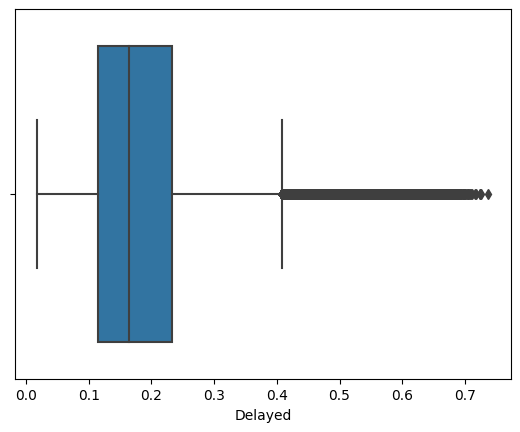

In [39]:
sns.boxplot(pseudo_labels_proba['Delayed'])

<AxesSubplot: xlabel='Not_Delayed'>

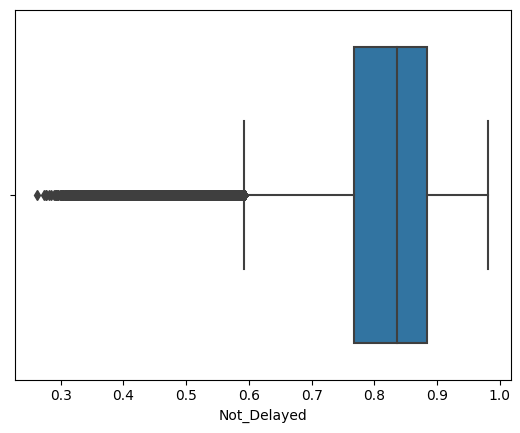

In [40]:
sns.boxplot(pseudo_labels_proba['Not_Delayed'])


In [41]:
# 임계치 도대체 얼만데?
# 그냥 0.5로 해버렸네..
'''
Not_Delayed    739999
Delayed          5000
'''

pseudo_labels_proba[pseudo_labels_proba['Not_Delayed'] > 0.50]

,Delayed,Not_Delayed
ID,,
TRAIN_000000,0.296672,0.703328
TRAIN_000001,0.155041,0.844959
TRAIN_000002,0.210290,0.789710
TRAIN_000003,0.318234,0.681766
TRAIN_000004,0.171041,0.828959
...,...,...
TRAIN_999995,0.135312,0.864688
TRAIN_999996,0.099004,0.900996
TRAIN_999997,0.129097,0.870903


In [42]:
train['Delay'].value_counts()

Not_Delayed    210001
Delayed         45000
Name: Delay, dtype: int64

# 준지도학습

In [24]:
# Generate pseudo-labels on the test set using the trained model
pseudo_labels = predictor.predict(unlabeled_data)

# Combine the original test set with the pseudo-labels





AttributeError: 'TabularDataset' object has no attribute 'add_column'

In [51]:
# labeled_data = unlabeled_data.add_column('Delay', pseudo_labels)
unlabeled_data['Delay'] = pseudo_labels.to_frame()['Delay']

In [52]:
unlabeled_data

,Month,Day_of_Month,Origin_Airport,Origin_State,Destination_Airport,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay,Dep_time_gb,Arr_time_gb,route_gb
ID,,,,,,,,,,,,,,,
TRAIN_000000,4,15,252,34,159,42,419.0,23,10,0,4319,Not_Delayed,9,11,2
TRAIN_000001,8,15,256,11,331,45,1250.0,22,8,12,310,Not_Delayed,2,5,1
TRAIN_000002,9,6,74,31,204,30,544.0,3,0,4,140,Not_Delayed,11,13,2
TRAIN_000003,7,10,195,4,119,28,2454.0,26,8,6,3021,Not_Delayed,4,12,1
TRAIN_000004,1,11,322,4,7,4,250.0,22,8,12,556,Not_Delayed,4,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRAIN_999995,9,18,256,11,270,36,678.0,26,8,6,2477,Not_Delayed,4,7,2
TRAIN_999996,5,30,122,32,242,21,223.0,22,3,12,2294,Not_Delayed,4,5,2
TRAIN_999997,6,28,248,4,159,42,1642.0,23,10,0,994,Not_Delayed,3,8,1


In [54]:

# Train a new model on the combined dataset with pseudo-labels
predictor_with_pseudo_labels = predictor.fit_pseudolabel(unlabeled_data, return_pred_prob = True, time_limit=3600)

Fitting predictor using the provided pseudolabeled examples as extra training data...
Fitting 13 L1 models ...
Fitting model: KNeighborsUnif_BAG_L1_PSEUDO ... Training model for up to 3600.0s of the 3600.0s of remaining time.
	-1.331	 = Validation score   (-log_loss)
	2.74s	 = Training   runtime
	1.47s	 = Validation runtime
Fitting model: KNeighborsDist_BAG_L1_PSEUDO ... Training model for up to 3595.65s of the 3595.65s of remaining time.
	-1.3414	 = Validation score   (-log_loss)
	2.88s	 = Training   runtime
	1.4s	 = Validation runtime
Fitting model: LightGBMXT_BAG_L1_PSEUDO ... Training model for up to 3591.22s of the 3591.22s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	-0.5709	 = Validation score   (-log_loss)
	75.62s	 = Training   runtime
	4.06s	 = Validation runtime
Fitting model: LightGBM_BAG_L1_PSEUDO ... Training model for up to 3489.17s of the 3489.17s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitti

In [60]:


# Make predictions on the test set using the model with pseudo-labels
test_preds = predictor_with_pseudo_labels[0].predict_proba(test_data)

# Evaluate the performance of the model with pseudo-labels
# test_perf = predictor_with_pseudo_labels.evaluate(test_data)
# print('Test performance with pseudo-labels:', test_perf)

In [59]:
predictor_with_pseudo_labels[1]

,Delayed,Not_Delayed
ID,,
TRAIN_000000,0.296672,0.703328
TRAIN_000001,0.155041,0.844959
TRAIN_000002,0.210290,0.789710
TRAIN_000003,0.318234,0.681766
TRAIN_000004,0.171041,0.828959
...,...,...
TRAIN_999995,0.135312,0.864688
TRAIN_999996,0.099004,0.900996
TRAIN_999997,0.129097,0.870903


In [61]:
test_preds

,Delayed,Not_Delayed
ID,,
TEST_000000,0.144784,0.855216
TEST_000001,0.227666,0.772334
TEST_000002,0.299001,0.700999
TEST_000003,0.384123,0.615877
TEST_000004,0.329852,0.670148
...,...,...
TEST_999995,0.293358,0.706642
TEST_999996,0.104293,0.895707
TEST_999997,0.253880,0.746120


In [62]:
sub = sub.set_index('ID')

sub['Not_Delayed'] = test_preds['Delayed']
sub['Delayed'] = test_preds['Not_Delayed']

In [64]:
sub.to_csv('준지도_dummy_automl.csv')

In [20]:
model_to_use = predictor.get_model_best()
model_pred = predictor.predict_proba(test_st, model=model_to_use)

In [24]:
pred = model_pred.reset_index()

In [27]:
sub = sub.set_index('ID')

In [37]:
sub['Delayed'] = None
sub['Not_Delayed'] = None

In [38]:
sub.loc[sub['Delayed'].isna(), 'Delayed'] = model_pred['Delayed']
sub.loc[sub['Not_Delayed'].isna(), 'Not_Delayed'] = model_pred['Not_Delayed']

In [39]:
sub['Delayed'] = sub['Delayed'].fillna(0)
sub['Not_Delayed'] = sub['Not_Delayed'].fillna(1)

In [42]:
sub.reset_index().to_csv('sub_20230414.csv', index=False)

# dummy

In [ ]:
# https://auto.gluon.ai/stable/api/autogluon.tabular.TabularPredictor.fit_pseudolabel.html